# Importing the modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Softmax, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Importing the modules

# Loading the data

In [2]:
df=pd.read_csv('./corpus_complet.tsv',delimiter='\t')

In [3]:
df.shape

(1427, 6)

In [4]:
df.head()

,url,title,body,preprocessed body,keywords,authenticity
0,https://www.timesnewroman.ro/life-death/au-inc...,Au început programările la vaccinare. 10 probl...,• Pentru că programările se fac în ordinea alf...,începe programare vaccinare problemă din prima...,"pentru, programările, ordinea, alfabetică, jud...",FAKE
1,https://www.timesnewroman.ro/monden/canibalii-...,Canibalii misogini din Mediaş susţin că locul ...,"Scandal în Mediaș, după ce un respectat caniba...",canibal misogin mediaș susține loc femeie crat...,"scandal, mediaș, după, respectat, canibal, loc...",FAKE
2,https://www.timesnewroman.ro/monden/nea-costel...,Nea Costel lansează un volum de poezie sub pse...,Încurajat de popularitatea neașteptată din ult...,nene costel lansa volum poezie pseudonim bețiv...,"Încurajat, popularitatea, neașteptată, ultima,...",FAKE
3,https://www.timesnewroman.ro/life-death/dumini...,Duminica Verde la Patriarhie. Azi în cutia mil...,BOR se alătură demersulului Ministerului Mediu...,duminică verde patriarhie cutie milă sine pute...,"alătură, demersulului, ministerului, mediului,...",FAKE
4,https://www.timesnewroman.ro/it-stiinta/alerta...,Alertă de vreme severă! Un nor tocmai ne-a pus...,ANM avertizează: urmează vreme severă în toată...,alertă sever nor pune scoate foaie hârtie ANM ...,"avertizează, urmează, vreme, severă, toată, ţa...",FAKE


In [5]:
df.tail()

,url,title,body,preprocessed body,keywords,authenticity
1422,https://www.digi24.ro/stiri/actualitate/65-de-...,65 de morți din cauza coronavirusului în România,Au fost raportate încă 13 decese ale unor pers...,angela Merkel an primi vineri doză vaccin prod...,"suceava,coronavirus,covid-19",TRUE
1423,https://www.digi24.ro/stiri/externe/certificat...,Certificatul de vaccinare cu AstraZeneca al ca...,"Angela Merkel, în vârstă de 66 de ani, a primi...",Ford motor anunța serie închidere fabricilor d...,"Angela Merkel,vaccin astrazeneca,cancelarul ge...",TRUE
1424,https://www.digi24.ro/stiri/sci-tech/auto/ford...,Ford închide temporar șase fabrici din SUA și ...,Ford Motor a anunţat o nouă serie de închideri...,ultim oră caz prezent românia confirmat caz pe...,"ford,pandemie coronavirus,semiconductori,criza...",TRUE
1425,https://www.digi24.ro/stiri/crestere-de-30-a-i...,Creștere de 30% a infectărilor cu coronavirus ...,În ultimele 24 de ore au fost 1.059 de cazuri ...,echipă feminin handbal CSM bucurești rata cali...,"terapie intensiva,coronavirus,coronavirus roma...",TRUE
1426,https://www.digi24.ro/stiri/sport/csm-bucurest...,CSM Bucureşti a ratat dramatic calificarea la ...,Echipa feminină de handbal CSM București a rat...,NaN,"Liga Campionilor,semifinale,CSM Bucureşti,fina...",TRUE


# The distribution of the articles

In [6]:
true_vals = [x for x in df['authenticity'] if x == 'TRUE']
fake_vals = [x for x in df['authenticity'] if x == 'FAKE']

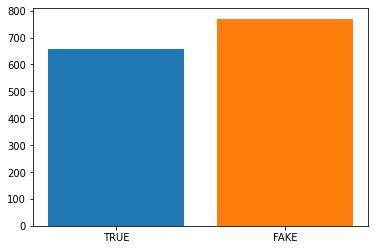

In [7]:
plt.bar(true_vals,len(true_vals))
plt.bar(fake_vals,len(fake_vals))
plt.show()

## Cleaning the dataset and formatting the labels

In [8]:
df = df.dropna()

In [9]:
labels = df.authenticity
convert = lambda x : 0 if x == 'FAKE' else 1
labels = [convert(label) for label in labels ]
count=0
for label in labels:
    if label == 1:
        count = count + 1

## Computing the wordcloud

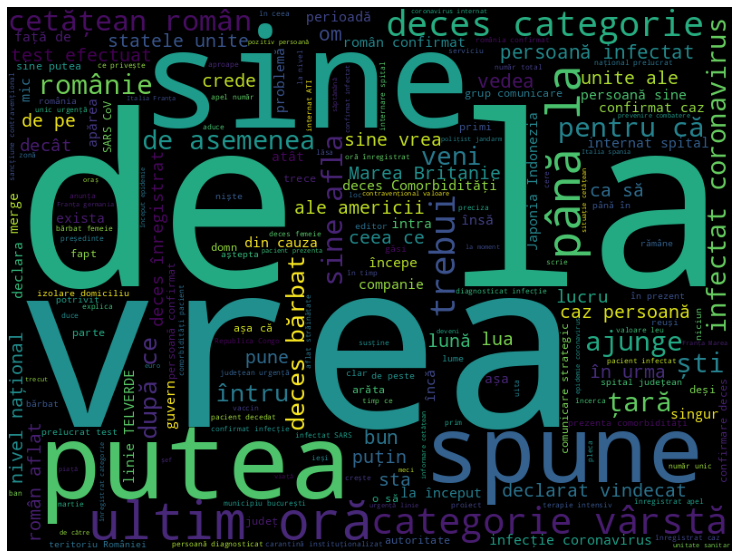

In [10]:
wordcloud = WordCloud(background_color='black', width=800, height=600)
wordcloud = wordcloud.generate(' '.join(df['preprocessed body']))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


## Splitting the dataset 

In [11]:
X_train, X_val, y_train, y_val = train_test_split(df['preprocessed body'] ,labels, test_size = 0.2, random_state=42)

# Building the model

### Tokenizer

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
voc_size = len(tokenizer.word_index) + 1
print('Vocabulary size: {}'.format(voc_size))

Vocabulary size: 12755


In [13]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = 256)
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=256)

print('Shape of train: {}'.format(X_train.shape))
print('Shape of validation: {}'.format(X_val.shape))

Shape of train: (1132, 256)
Shape of validation: (284, 256)


### Modeling

In [ ]:
inputs = Input(shape=(256,), dtype='int32')

model = Sequential(
    [Embedding(voc_size, 500),
    SpatialDropout1D(0.2),
    LSTM(256),
    Dropout(0.3),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(1,activation = 'sigmoid')]
)


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [15]:
y_val = np.array(y_val)
y_train = np.array(y_train)

In [ ]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, batch_size=16)

Epoch 1/50
 3/71 [>.............................] - ETA: 1:21 - loss: 2.3290 - accuracy: 0.5208

In [17]:
model.save('model_prl_overfitted.h5')